In [69]:
import xarray as xr

nc_file = "D:\Min\Review GCM\pr_day_CanESM5_ssp585_r1i1p1f1_gn_20150101-21001231.nc"

ds = xr.open_dataset(nc_file)
 
pr_data = ds['pr']
ds.close()

In [70]:
pr_data = pr_data* 86400 

In [71]:
import numpy as np 

In [72]:
import xarray as xr

nc_file = "tas_day_CanESM5_ssp585_r1i1p1f1_gn_20150101-21001231.nc"

ds = xr.open_dataset(nc_file)
 
tas_data = ds['tas']
ds.close()

In [73]:
tas_data = tas_data - 273.15

In [74]:
file_pattern = "D:\Min\Review GCM\hur\*.nc"

combined_dataset = xr.open_mfdataset(file_pattern, combine='by_coords')

hur_data = combined_dataset["hur"].sel(plev=100000)

In [75]:
test_pr = pr_data.sel(time = "2021-01-01").to_dataframe().reset_index()
test_tas = tas_data.sel(time = "2021-01-01").to_dataframe().reset_index()
hur_data = hur_data.sel(time = "2021-01-01").to_dataframe().reset_index()

In [110]:
import numpy as np
from scipy.spatial.distance import cdist
from typing import Iterable

rows = 181
columns = 361
latitudes = np.linspace(-90, 90, rows)
longitudes = np.linspace(-180, 180, columns)
lat_mesh, lon_mesh = np.meshgrid(latitudes, longitudes)
unknown_locations = np.column_stack((lat_mesh.flatten(), lon_mesh.flatten()))
def idw(known_points: np.ndarray,
                               unknown_location: Iterable,
                               number_of_neighbours=5,
                               power=2.) -> float:

    # Pre-process unknown location parameter
    if not isinstance(unknown_location, np.ndarray):
        unknown_location = np.array(unknown_location)

    if len(unknown_location.shape) != len(known_points.shape):
        unknown_location = unknown_location[np.newaxis, ...]

    # Calculate distances using scipy.spatial.distance.cdist
    distances = cdist(unknown_location, known_points[:, :-1])

    # Check if any distance is equal to 0 - then return this value
    if not np.all(distances[0]):

        zer_pos = np.where(distances == 0)
        result = known_points[zer_pos[1], -1][0]
        return result

    # Get n closest neighbours...
    sdists = distances.argsort()
    sdists = sdists[0, :number_of_neighbours]
    dists = distances[0, sdists]
    values = known_points[sdists][:, -1]

    # Create weights
    weights = 1 / dists**power

    # Estimate value using vectorized operations
    result = np.sum(weights * values) / np.sum(weights)
    return result


In [77]:
import pandas as pd

In [81]:
import warnings
warnings.filterwarnings(action='ignore')
results = []
for unknown_location in unknown_locations:
    data = test_pr[["lat", "lon", 'pr']].values
    result = idw(data, unknown_location, number_of_neighbours=5, power=2)
    results.append(result)

In [82]:
column_names = ['pr']
pr_interp  = pd.DataFrame(results, columns=column_names)

In [85]:
results = []
for unknown_location in unknown_locations:
    data = test_tas[["lat", "lon", 'tas']].values
    result = idw(data, unknown_location, number_of_neighbours=5, power=2)
    results.append(result)
column_names = ['tas']
tas_interp  = pd.DataFrame(results, columns=column_names)

In [111]:
results = []
for unknown_location in unknown_locations:
    data = hur_data[["lat", "lon", 'hur']].values
    result = idw(data, unknown_location, number_of_neighbours=5, power=2)
    results.append(result)
column_names = ['hur']
hur_interp  = pd.DataFrame(results, columns=column_names)

In [113]:
unknown_locations = pd.DataFrame(unknown_locations, columns=['lat', 'lon'])

In [91]:
tas_interp = pd.concat([unknown_locations, tas_interp], axis=1)

In [92]:
pr_interp = pd.concat([unknown_locations, pr_interp], axis=1)

In [114]:
hur_interp = pd.concat([unknown_locations, hur_interp], axis=1)

In [94]:
# Compare 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

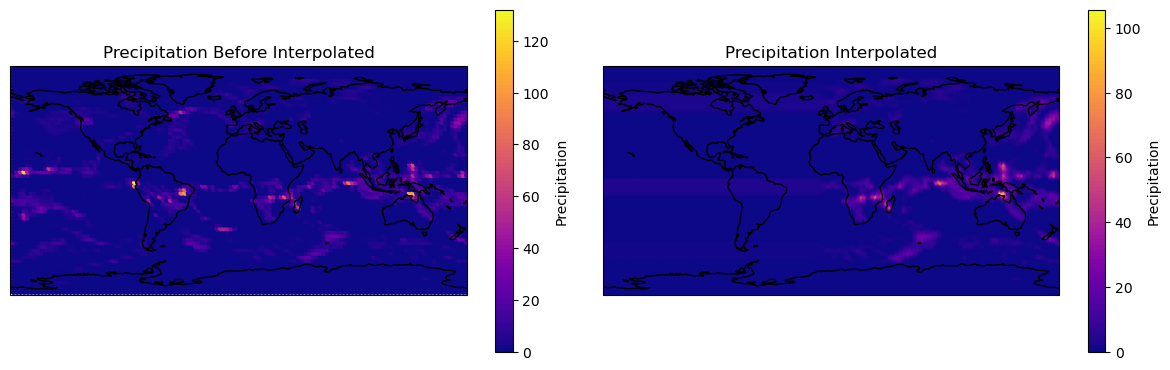

In [99]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Plotting the first scatter plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1: Precipitation Before Interpolated
lons = test_pr['lon'].values
lats = test_pr['lat'].values
precipitation = test_pr['pr'].values

num_colors = 100
cmap = plt.get_cmap('plasma', num_colors)
norm = plt.Normalize(precipitation.min(), precipitation.max())
sc = axes[0].scatter(lons, lats, c=precipitation, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=axes[0], shrink=0.6, orientation='vertical', label='Precipitation')
axes[0].set_title('Precipitation Before Interpolated')
axes[0].coastlines()

# Plot 2: Precipitation Interpolated
lons = pr_interp['lon'].values
lats = pr_interp['lat'].values
precipitation = pr_interp['pr'].values

num_colors = 100
cmap = plt.get_cmap('plasma', num_colors)
norm = plt.Normalize(precipitation.min(), precipitation.max())
sc = axes[1].scatter(lons, lats, c=precipitation, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=axes[1], shrink=0.6, orientation='vertical', label='Precipitation')
axes[1].set_title('Precipitation Interpolated')
axes[1].coastlines()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


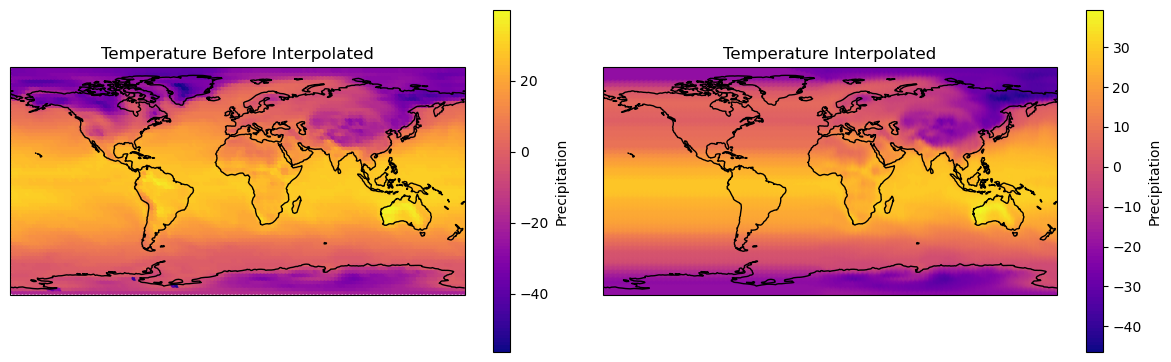

In [102]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Plotting the first scatter plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1: Precipitation Before Interpolated
lons = test_tas['lon'].values
lats = test_tas['lat'].values
tas = test_tas['tas'].values

num_colors = 100
cmap = plt.get_cmap('plasma', num_colors)
norm = plt.Normalize(tas.min(), tas.max())
sc = axes[0].scatter(lons, lats, c=tas, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=axes[0], shrink=0.6, orientation='vertical', label='Temperature')
axes[0].set_title('Temperature Before Interpolated')
axes[0].coastlines()

# Plot 2: Precipitation Interpolated
lons = tas_interp['lon'].values
lats = tas_interp['lat'].values
tas = tas_interp['tas'].values

num_colors = 100
cmap = plt.get_cmap('plasma', num_colors)
norm = plt.Normalize(tas.min(), tas.max())
sc = axes[1].scatter(lons, lats, c=tas, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=axes[1], shrink=0.6, orientation='vertical', label='Temperature')
axes[1].set_title('Temperature Interpolated')
axes[1].coastlines()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

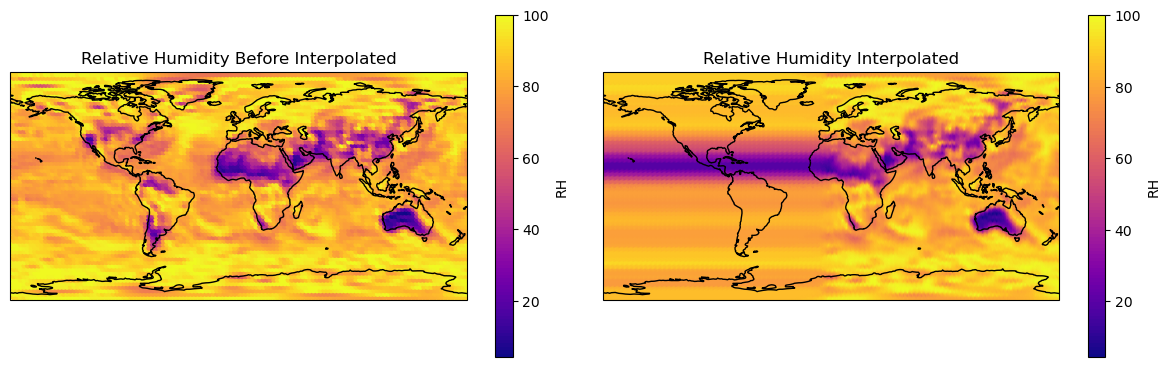

In [115]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Plotting the first scatter plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1: Precipitation Before Interpolated
lons = hur_data['lon'].values
lats = hur_data['lat'].values
hur = hur_data['hur'].values

num_colors = 100
cmap = plt.get_cmap('plasma', num_colors)
norm = plt.Normalize(hur.min(), hur.max())
sc = axes[0].scatter(lons, lats, c=hur, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=axes[0], shrink=0.6, orientation='vertical', label='RH')
axes[0].set_title('Relative Humidity Before Interpolated')
axes[0].coastlines()

# Plot 2: Precipitation Interpolated
lons = hur_interp['lon'].values
lats = hur_interp['lat'].values
hur = hur_interp['hur'].values

num_colors = 100
cmap = plt.get_cmap('plasma', num_colors)
norm = plt.Normalize(hur.min(), hur.max())
sc = axes[1].scatter(lons, lats, c=hur, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=axes[1], shrink=0.6, orientation='vertical', label='RH')
axes[1].set_title('Relative Humidity Interpolated')
axes[1].coastlines()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [116]:
#get tdew 
def calculate_dewpoint(temp, humidity):
    A = 17.27
    B = 237.7
    alpha = ((A * temp) / (B + temp)) + np.log(humidity/100.0)
    return (B * alpha) / (A - alpha)

In [119]:
rh = hur_interp['hur']
t = tas_interp['tas']

In [ ]:
tdew = calculate_dewpoint(temp = t, humidity = rh)

In [121]:
tdew = pd.DataFrame({
    'lat': tas_interp['lat'].values,
    'lon': tas_interp['lon'].values,
    'tdew': tdew
})


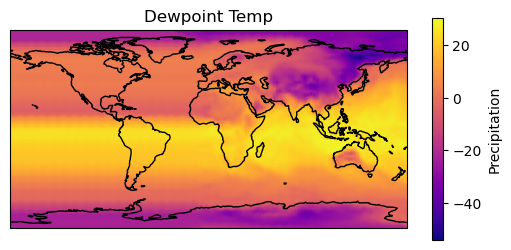

In [124]:
lons = tdew['lon'].values
lats = tdew['lat'].values
tdew= tdew['tdew'].values

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

num_colors = 100

cmap = plt.get_cmap('plasma', num_colors)

norm = plt.Normalize(tdew.min(), tdew.max())
sc = ax.scatter(lons, lats, c=tdew, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, orientation='vertical', label='Precipitation')

ax.set_title('Dewpoint Temp')

ax.coastlines()
#ax.gridlines()

# Show the plot
plt.show()